# Show Raw Data

In [1]:
import sys
import math
from pathlib import Path

from eztrack import (
    preprocess_ieeg,
    lds_raw_fragility,
)
from eztrack.io import read_derivative_npy
from eztrack.utils import warn
from mne_bids import read_raw_bids, BIDSPath, get_entity_vals
from mne import concatenate_raws
sys.path.append('../../')

from sickkids.fragility.run_fragility_analysis import run_analysis

In [30]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import mne
# mne.viz.set_3d_backend("notebook")

In [3]:
# %gui qt
# %matplotlib qt
%matplotlib inline

In [4]:
def preprocess_data(bids_path, reference, deriv_path=None, figures_path=None, verbose=True, overwrite=False):
    subject = bids_path.subject

    # set where to save the data output to
    if deriv_path is None:
        deriv_path = (
                bids_path.root
                / "derivatives"
                / "1000Hz"
                / "fragility"
                / reference
                / f"sub-{subject}"
        )
    if figures_path is None:
        figures_path = (
                bids_path.root
                / "derivatives"
                / "figures"
                / "1000Hz"
                / "fragility"
                / reference
                / f"sub-{subject}"
        )

    # use the same basename to save the data
    deriv_basename = bids_path.basename

    # if len(list(deriv_path.rglob(f'{deriv_basename}*'))) > 0 and not overwrite:
    #     warn('Need to set overwrite to True if you want '
    #          f'to overwrite {deriv_basename}')
    #     return

    # load in the data
    raw = read_raw_bids(bids_path, verbose=False)
#     print(raw.ch_names)
    raw = raw.pick_types(seeg=True, ecog=True, eeg=True, misc=False, exclude=[])
#     print(raw.ch_names)
    raw.load_data()
#     print(raw.ch_names)

    # pre-process the data using preprocess pipeline
    datatype = bids_path.datatype
    print('Power Line frequency is : ', raw.info["line_freq"])
    raw = preprocess_ieeg(raw, l_freq=0.5, h_freq=300,
                         verbose=verbose, method="simple", drop_chs=False)
#     print(raw.ch_names)
#     raw = raw.pick_types(seeg=True, ecog=True, eeg=True, misc=True, exclude=[])
    return raw

In [5]:
# the root of the BIDS dataset
root = Path("/Users/adam2392/OneDrive - Johns Hopkins/sickkids/")

# define BIDS entities
subjects = [
    "E1",
    # 'E2',
    # 'E3',
#     'E4',
    # 'E5', 'E6'
]

session = "postsurgery"  # only one session

# pre, Sz, Extraoperative, post
# task = "pre"
acquisition = "ecog"
datatype = "ieeg"
extension = ".vhdr"

# analysis parameters
reference = 'average'

sessions = [
    'extraoperative',
    'preresection',
    'intraresection',
    'postresection']

raws = []
postraws = []

# get the runs for this subject
subjects = get_entity_vals(root, "subject")
for subject in subjects:
    if subject != 'E4':
        continue
    ignore_subs = [sub for sub in subjects if sub != subject]
    sessions = get_entity_vals(root, 'session', ignore_subjects=ignore_subs)
    
    for session in sessions:
        ignore_sessions = [ses for ses in sessions if ses != session]
        ignore_set = {
            'ignore_subjects': ignore_subs,
            'ignore_sessions': ignore_sessions,
        }
        all_tasks = get_entity_vals(root, "task", **ignore_set)
        tasks = all_tasks
        # tasks = ['pre']

        for task in tasks:
            print(f"Analyzing {task} task.")
            ignore_tasks = [tsk for tsk in all_tasks if tsk != task]
            ignore_set['ignore_tasks'] = ignore_tasks
            runs = get_entity_vals(
                root, 'run', **ignore_set
            )
#             print(ignore_subs)
#             print(ignore_tasks)
#             print(f'Found {runs} runs for {task} task.')

            for idx, run in enumerate(runs):
                # create path for the dataset
                bids_path = BIDSPath(
                    subject=subject,
                    session=session,
                    task=task,
                    run=run,
                    datatype=datatype,
                    acquisition=acquisition,
                    suffix=datatype,
                    root=root,
                    extension=extension,
                )
                print(f"Analyzing {bids_path}")

                raw = preprocess_data(bids_path, reference=reference)
        
                break
            break
        if session in ['intraresection', 'postresection']:
            postraws.append(raw)
        else:
            raws.append(raw)
#         break
    break

Analyzing ictal task.
Analyzing /Users/adam2392/OneDrive - Johns Hopkins/sickkids/sub-E4/ses-extraoperative/ieeg/sub-E4_ses-extraoperative_task-ictal_acq-ecog_run-01_ieeg.vhdr


<ipython-input-4-913c087c4b23>:34: RuntimeWarning: Did not find any events.tsv associated with sub-E4_ses-extraoperative_task-ictal_acq-ecog_run-01.

The search_str was "/Users/adam2392/OneDrive - Johns Hopkins/sickkids/sub-E4/**/sub-E4_ses-extraoperative*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-4-913c087c4b23>:34: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['C4', 'C5', 'C6', 'C7', 'C8', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C27', 'C28', 'C29', 'C30', 'C31', 'C32', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'F2AL1', 'F2AL2', 'F2AL3', 'F2AL4', 'F2AL5', 'F2AL6', 'F2BC1', 'F2BC2', 'F2BC3', 'F2BC4', 'F2BC5', 'F2BC6', 'F2CL1', 'F2CL2', 'F2CL3', 'F2CL4', 'F2CL5', 'F2CL6', 'C67', 'C68', 'C69', 'C70', 'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79', 'C80', 'C81', 'C82', 'C83', 'C84', 'C85', 'C86', 'C87', 'C88', 'C89'

Power Line frequency is :  60
Analyzing post task.
Analyzing /Users/adam2392/OneDrive - Johns Hopkins/sickkids/sub-E4/ses-postresection/ieeg/sub-E4_ses-postresection_task-post_acq-ecog_run-01_ieeg.vhdr


<ipython-input-4-913c087c4b23>:34: RuntimeWarning: Did not find any events.tsv associated with sub-E4_ses-postresection_task-post_acq-ecog_run-01.

The search_str was "/Users/adam2392/OneDrive - Johns Hopkins/sickkids/sub-E4/**/sub-E4_ses-postresection*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-4-913c087c4b23>:34: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['C6', 'C7', 'C8', 'C14', 'C15', 'C16', 'C21', 'C22', 'C23', 'C24', 'C29', 'C30', 'C31', 'C32', 'C37', 'C38', 'C39', 'C40', 'C43', 'C44', 'C45', 'C46', 'C48', 'C67', 'C68', 'C69', 'C70', 'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79', 'C80', 'C81', 'C82', 'C83', 'C84', 'C85', 'C86', 'C87', 'C88', 'C89', 'C90', 'C91', 'C92', 'C93', 'C94', 'C95', 'C96', 'C97', 'C98', 'C99', 'C100', 'C101', 'C102', 'C103', 'C104', 'C105', 'C106', 'C107', 'C108', 'C109', 'C110', 'C111', 'C112', 'C113', 'C114', 'C115', 'C116', 'C117', 'C118', 'C119', 'C120', 'C121',

Power Line frequency is :  60
Analyzing pre task.
Analyzing /Users/adam2392/OneDrive - Johns Hopkins/sickkids/sub-E4/ses-preresection/ieeg/sub-E4_ses-preresection_task-pre_acq-ecog_run-01_ieeg.vhdr


<ipython-input-4-913c087c4b23>:34: RuntimeWarning: Did not find any events.tsv associated with sub-E4_ses-preresection_task-pre_acq-ecog_run-01.

The search_str was "/Users/adam2392/OneDrive - Johns Hopkins/sickkids/sub-E4/**/sub-E4_ses-preresection*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-4-913c087c4b23>:34: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['C4', 'C5', 'C6', 'C7', 'C8', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C27', 'C28', 'C29', 'C30', 'C31', 'C32', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'F2AL1', 'F2AL2', 'F2AL3', 'F2AL4', 'F2AL5', 'F2AL6', 'F2BC1', 'F2BC2', 'F2BC3', 'F2BC4', 'F2BC5', 'F2BC6', 'F2CL1', 'F2CL2', 'F2CL3', 'F2CL4', 'F2CL5', 'F2CL6', 'C67', 'C68', 'C69', 'C70', 'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79', 'C80', 'C81', 'C82', 'C83', 'C84', 'C85', 'C86', 'C87', 'C88', 'C89', 'C90

Power Line frequency is :  60


In [6]:
session_raw = concatenate_raws(raws)
postses_raw = concatenate_raws(postraws)

In [31]:
session_raw.drop_channels(session_raw.info['bads'])
postses_raw.drop_channels(postses_raw.info['bads'])

<RawBrainVision | sub-E4_ses-postresection_task-post_acq-ecog_run-01_ieeg.eeg, 23 x 247040 (120.6 s), ~43.4 MB, data loaded>

In [48]:
events, event_id = mne.events_from_annotations(session_raw)

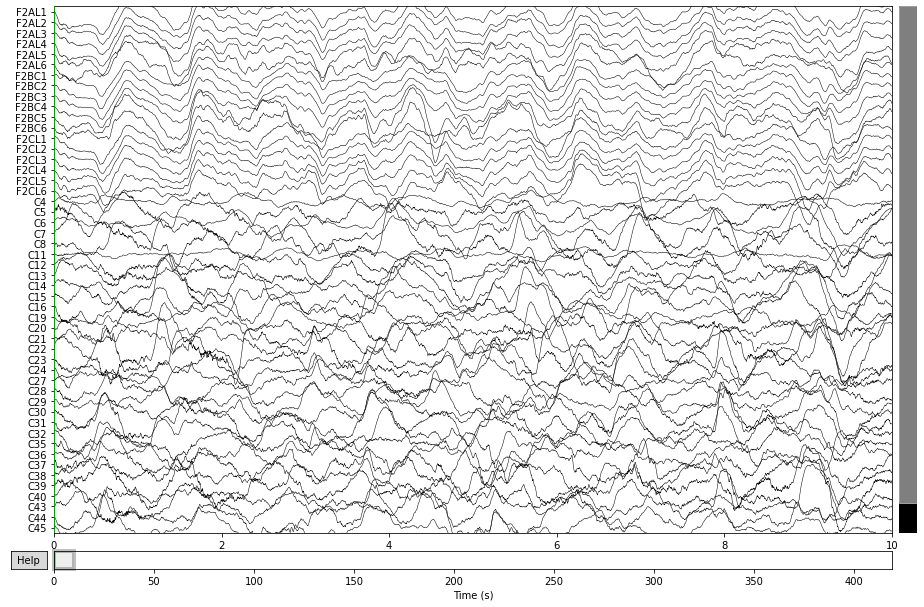

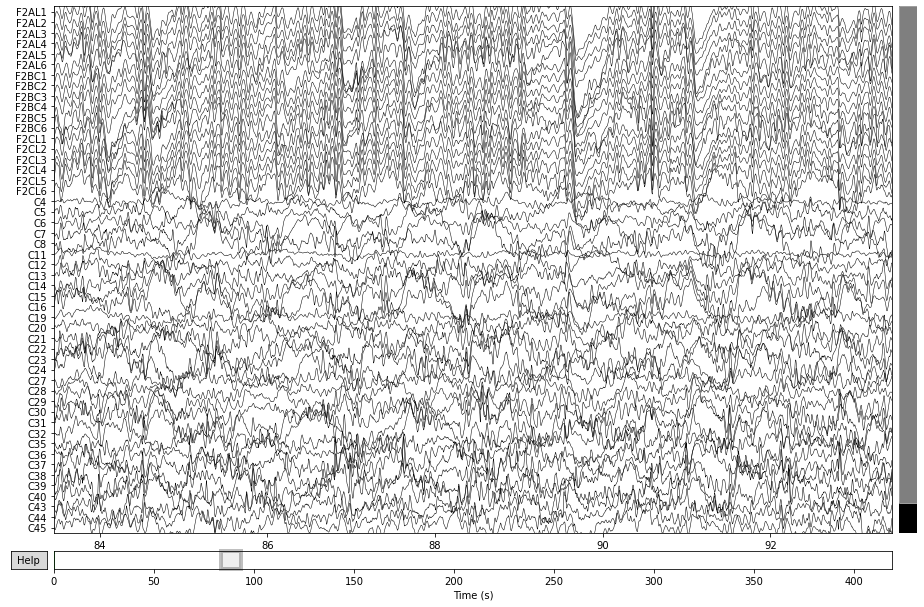

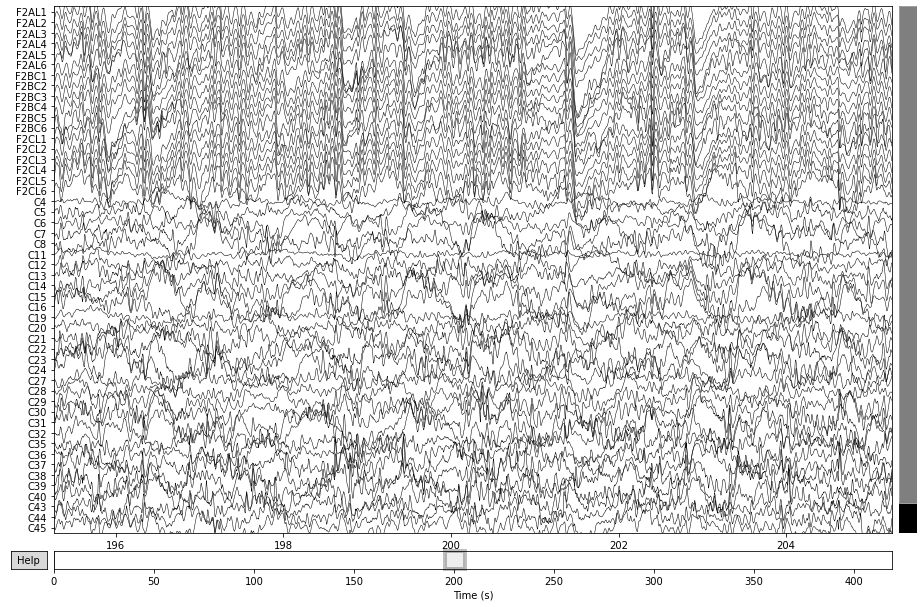

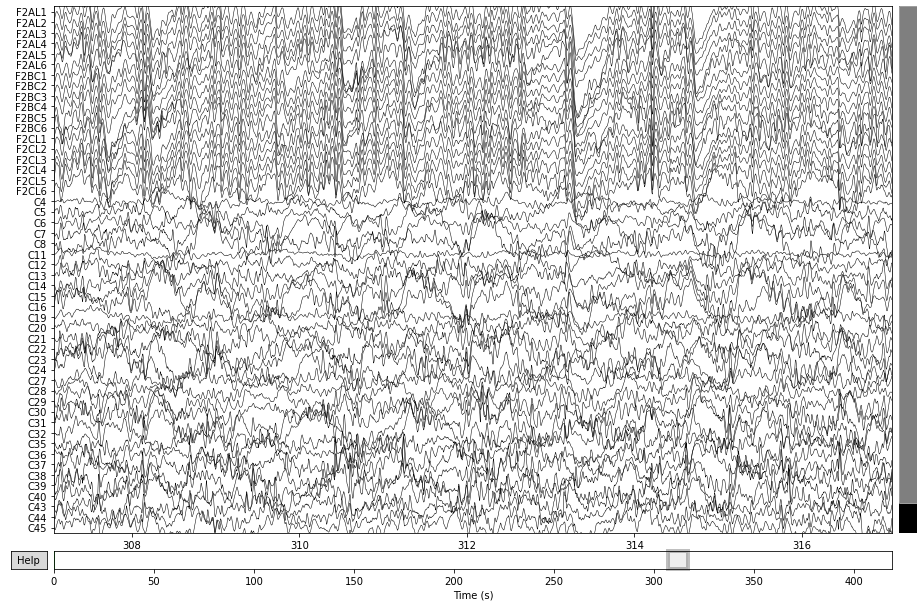

In [53]:
session_raw.set_annotations(None)
for idx in range(events.shape[0]):
    onset = events[idx, 0] / session_raw.info['sfreq']
    session_raw.plot(start=onset, scalings={'seeg': 1e-4, 'ecog': 1e-4}, 
                     clipping=None, n_channels=50, show_scalebars=False,
                     color={'ecog': 'black', 'seeg': 'black'}
    #                 show_scrollbars=False
                    )

In [14]:
deriv_root = root / 'derivatives' / "figures" \
                / f"{int(raw.info['sfreq'])}Hz" \
                / "raw" \
                / reference \
                / f"sub-{subject}"
deriv_root.mkdir(exist_ok=True, parents=True)
fig_basename = bids_path.copy().update(extension='.pdf').basename
print(deriv_root)
print(fig_basename)

/Users/adam2392/OneDrive - Johns Hopkins/sickkids/derivatives/figures/2049Hz/raw/average/sub-E4
sub-E4_ses-extraoperative_task-interictalawake_acq-ecog_run-01_ieeg.pdf


In [15]:
scale = 500e-6
fig = raw.plot(
    scalings={
        'ecog': scale, 
        'seeg': scale
    }, n_channels=len(raw.ch_names)
)
fig.savefig(deriv_root / fig_basename)

In [12]:
print(raw.info['bads'])

['C20', 'C27', 'C28']


# Try some stuff - kernel Regression

In [7]:
from sklearn.kernel_ridge import KernelRidge

from eztrack.fragility import DiscreteLinearSystem

In [90]:
clf = KernelRidge(alpha=1e-8, kernel='laplacian', gamma=None)

In [91]:
eegdata = raw.get_data(start=0, stop=250)
print(eegdata.shape)

(66, 250)


In [109]:
X = eegdata[:, :-1].T
Y = eegdata[:, 1:].T

print(X.shape, Y.shape)

(249, 66) (249, 66)


In [110]:
clf.fit(X, Y)

KernelRidge(alpha=1e-08, kernel='laplacian')

In [111]:
yhat = clf.predict(X[1:2, :])
print(yhat.shape)

(1, 66)


In [112]:
print(clf.dual_coef_.shape)

(249, 66)


Done
6.662558227251915e-09


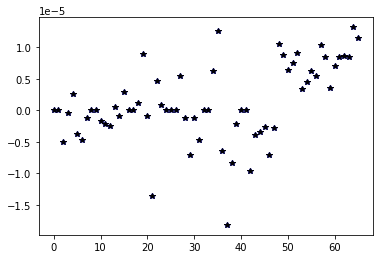

In [114]:
plt.plot(yhat.flatten(), 'b*')
plt.plot(Y[1, :], 'k*')
print('Done')
print(np.sum(Y[1,:] - yhat.flatten()))

In [115]:
print(clf.get_params())

{'alpha': 1e-08, 'coef0': 1, 'degree': 3, 'gamma': None, 'kernel': 'laplacian', 'kernel_params': None}


In [116]:
print(clf.dual_coef_.shape)
print(clf.X_fit_.shape)

(249, 66)
(249, 66)


In [119]:
K = clf._get_kernel(X, X[0:1, :])
print(K.shape)

(249, 1)


<AxesSubplot:>

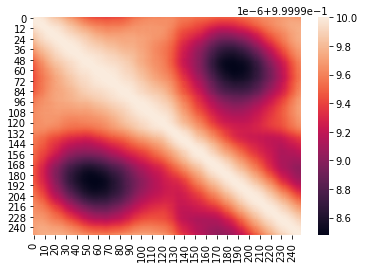

In [23]:
sns.heatmap(K)

In [24]:
import numpy as np
print(np.abs(np.linalg.eigvals(K)))

[2.48999865e+02 7.96616624e-05 3.36741695e-05 1.04392056e-05
 5.60611878e-06 2.70305670e-06 1.19631746e-06 8.13762003e-07
 3.17706093e-07 2.48010837e-07 1.22804039e-07 4.08440487e-08
 3.73582689e-08 2.45142665e-08 2.32941015e-08 1.32560786e-08
 1.14064131e-08 5.07996713e-09 4.07747375e-09 3.78509017e-09
 1.93017964e-09 1.74763860e-09 1.64454807e-09 1.34457714e-09
 1.02145778e-09 8.82976602e-10 6.86758769e-10 5.27702999e-10
 5.27702999e-10 3.47965733e-10 3.35319193e-10 2.68849402e-10
 1.94194522e-10 1.94194522e-10 1.90545969e-10 1.90545969e-10
 1.08212036e-10 1.08212036e-10 8.45369799e-11 8.45369799e-11
 8.71663150e-11 8.71663150e-11 6.23814734e-11 6.23814734e-11
 5.13229182e-11 4.55225879e-11 4.55225879e-11 4.13674849e-11
 4.13674849e-11 3.50075843e-11 2.21174349e-11 2.21174349e-11
 1.29016872e-11 1.29016872e-11 9.08068333e-12 9.80945796e-15
 5.08251775e-15 4.36932780e-15 4.36932780e-15 3.95481854e-15
 3.95481854e-15 3.53523365e-15 3.39578962e-15 3.39578962e-15
 3.42607252e-15 3.426072

/Users/adam2392/Documents/eztrack/eztrack/fragility/linearsystem.py:326: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x14a5e68e0>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend([points, unit_circle], ["Eigenvalues", "Unit circle"], loc=1)


<AxesSubplot:xlabel='Real part', ylabel='Imaginary part'>

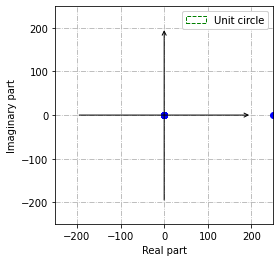

In [25]:
lds = DiscreteLinearSystem(K)
lds.plot_eigs()